# Level C instructions:

### Some steps to get familiar with the data:

- Have a look at the rgb images in the folder "ARKitScenesData/47333473/47333473_frames/lowres_wide/" to get an impression of the scene that we are working with
- To start, run the notebook which will show ground truth visualization, example detection, and full pipeline results

## Level C

The task is to generate 3D bounding boxes that mark the estimated location of objects in the environment.
This time using OWLV2 detections with SAM refinement.

Required to pass the level:
- Functional pipeline with visualization of the estimated 3D bounding boxes
- mIOU score > 0.25 of the bounding box estimates when comparing to ground-truth (For classes: "bed", "sofa", "chair", "table", "shelf")
- Understand and explain the code flow and steps required for the complete pipeline

## 1. Dependencies and Imports


In [15]:
# Install dependencies
!pip install --upgrade pip
!pip install torch==2.4.0+cu121 torchvision==0.19.0+cu121 --index-url https://download.pytorch.org/whl/cu121
!pip install transformers==4.44.0 huggingface-hub==0.24.0 pillow numpy opencv-python open3d ipympl rerun-sdk[notebook]==0.24.1

Looking in indexes: https://download.pytorch.org/whl/cu121


In [16]:
# Import required libraries
import os
from typing import Dict, List, Optional, Tuple
import cv2
import numpy as np
import open3d as o3d
from PIL import Image
import torch

# Import lab utility functions
from lab_utils.data_utils import get_frame_list, load_camera_poses, validate_and_align_frame_data
from lab_utils.ground_truth import load_ground_truth_data
from lab_utils.tsdf_utils import build_tsdf_point_cloud
from lab_utils.viz_eval import visualize_3d_scene_bbox_results, evaluate_level_results
from lab_utils.model_loaders import load_owlv2_model, load_sam_model
from lab_utils.level_specific_viz import visualize_level_c_example
from lab_utils.batch_processing_utils import process_frames_with_sam

## 2. Configuration


In [17]:
class Config:
    # Scene Configuration
    SCENE_ID = "47333473"
    BASE_PATH = f"ARKitScenesData/{SCENE_ID}/{SCENE_ID}_frames"
    RGB_PATH = os.path.join(BASE_PATH, "lowres_wide")
    DEPTH_PATH = os.path.join(BASE_PATH, "lowres_depth")
    INTRINSICS_PATH = os.path.join(BASE_PATH, "lowres_wide_intrinsics")
    TRAJ_FILE_PATH = os.path.join(BASE_PATH, "lowres_wide.traj")
    
    # Detection Classes
    OBJECT_CLASSES = ["bed", "chair", "sofa", "table", "shelf"]
    
    # Level C Configuration
    LEVEL_C_CONFIG = {
        'frame_skip': 3,
        'max_frames': 1000,
        'detection_threshold': 0.4,       #[modify]
        'sam_confidence_threshold': 0.3,  #[modify]
        'overlap_threshold': 0.4,         #[modify]
        'min_observations': 5,            #[modify]
        'sam_model_size': 'base',
        'max_points_per_object': 2000,
        'example_viz_index': 65,
        'sam_batch_size': 5,
        'required_miou': 0.25,            #[Do not modify]
    }
    
    # TSDF Configuration
    TSDF_CONFIG = {
        'frame_skip': 3, 'depth_scale': 1000.0, 'depth_trunc': 7.0,
        'voxel_size': 0.04, 'batch_size': 20, 'max_frames': 1000,
        'volume_length': 30.0, 'resolution': 512,
    }

    # GT and Display Configuration
    GT_CONFIG = {
        'allowed_classes': None, 'mesh_downsample_points': 75000,
        'show_mesh': True, 'show_annotations': True
    }
    RERUN_WIDTH, RERUN_HEIGHT = 1200, 700

def validate_config(config: Config) -> None:
    """Validate and initialize configuration parameters."""
    config.GT_CONFIG['allowed_classes'] = config.OBJECT_CLASSES
    print(f"Configuration validated.")

# Create and validate config
config = Config()
validate_config(config)

Configuration validated.


## 3. Scene Understanding - Ground Truth Visualization

Let's start by visualizing the ground truth data to understand what we're working with:

In [18]:
# Load and visualize ground truth to understand the scene
print("Loading ground truth data to understand our scene...")

gt_annotations, gt_mesh = load_ground_truth_data(
    config.SCENE_ID, 
    config.BASE_PATH,
    config.GT_CONFIG
)

if gt_annotations:
    print(f"✓ Loaded {len(gt_annotations)} ground truth annotations")
    class_counts = {}
    for ann in gt_annotations:
        class_counts[ann['label']] = class_counts.get(ann['label'], 0) + 1
    print(f"Objects in scene: {class_counts}")

if gt_mesh:
    print(f"✓ Loaded ground truth mesh with {len(gt_mesh.points)} points")

# Visualize the ground truth scene
visualize_3d_scene_bbox_results(
    point_cloud=None,
    detections_3d=None,
    gt_annotations=gt_annotations,
    gt_mesh=gt_mesh,
    show_ground_truth=True,
    show_gt_mesh=True,
    show_object_pointclouds=False,
    title=f"Ground Truth Scene {config.SCENE_ID} - What We Want to Detect",
    config=config
)


Loading ground truth data to understand our scene...
Loading ground truth annotations from: ARKitScenesData/47333473/47333473_frames/../47333473_3dod_annotation.json
Successfully processed 6 ground truth annotations
Loading ground truth mesh from: ARKitScenesData/47333473/47333473_frames/../47333473_3dod_mesh.ply
Loaded mesh with 75000 points
✓ Loaded 6 ground truth annotations
Objects in scene: {'bed': 1, 'shelf': 1, 'sofa': 2, 'table': 1, 'chair': 1}
✓ Loaded ground truth mesh with 75000 points
Visualizing: Ground Truth Scene 47333473 - What We Want to Detect


HTML(value='<div id="8e243339-db4f-4e3e-b98c-250a57f92347"><style onload="eval(atob(\'KGFzeW5jIGZ1bmN0aW9uICgp…

Viewer()

3D visualization complete


## 4. Execution Functions

These functions orchestrate the different parts of the pipeline:

In [19]:
def run_ground_truth_visualization(config: Config) -> None:
    """Execute ground truth visualization."""
    print("=" * 60)
    print("GROUND TRUTH VISUALIZATION")
    print("=" * 60)
    
    gt_annotations, gt_mesh = load_ground_truth_data(
        config.SCENE_ID, 
        config.BASE_PATH,
        config.GT_CONFIG
    )
    
    if gt_annotations:
        print(f"Loaded {len(gt_annotations)} ground truth annotations")
        class_counts = {}
        for ann in gt_annotations:
            class_counts[ann['label']] = class_counts.get(ann['label'], 0) + 1
        print(f"GT objects by class: {class_counts}")
    
    if gt_mesh:
        print(f"Loaded ground truth mesh with {len(gt_mesh.points)} points")
    
    visualize_3d_scene_bbox_results(
        point_cloud=None,
        detections_3d=None,
        gt_annotations=gt_annotations,
        gt_mesh=gt_mesh,
        show_ground_truth=True,
        show_gt_mesh=True,
        show_object_pointclouds=False,
        title=f"Ground Truth Only - Scene {config.SCENE_ID}",
        config=config
    )
    
    print("Ground truth visualization complete!")


def run_example_visualization(config: Config) -> Dict:
    """Execute example visualization."""
    print("\n" + "=" * 60)
    print("EXAMPLE VISUALIZATION")
    print("=" * 60)
    
    example_results = visualize_level_c_example(
        config, 
        frame_index=config.LEVEL_C_CONFIG['example_viz_index']
    )
    
    print("Example visualization complete!")
    return example_results


def run_full_pipeline(config: Config) -> Dict:
    """Execute the complete SAM-enhanced 3D scene analysis pipeline."""
    print("\n" + "=" * 60)
    print("FULL PIPELINE EXECUTION")
    print("=" * 60)
    
    owl_processor, owl_model, device = load_owlv2_model()
    sam_model, sam_processor, _ = load_sam_model(
        model_size=config.LEVEL_C_CONFIG['sam_model_size'], 
        device=device
    )
    
    camera_poses = load_camera_poses(config.TRAJ_FILE_PATH)
    frames_metadata = get_frame_list(config.RGB_PATH, config.LEVEL_C_CONFIG['frame_skip'])
    aligned_frames = validate_and_align_frame_data(
        frames_metadata, camera_poses, config.RGB_PATH, 
        config.DEPTH_PATH, config.INTRINSICS_PATH, timestamp_tolerance=0.1
    )
    
    if not aligned_frames:
        print("ERROR: No aligned frames found! Check data paths.")
        return {'detections_3d': [], 'frame_results': {}, 'statistics': {}}
    
    frames_for_detection = aligned_frames[:config.LEVEL_C_CONFIG['max_frames']]
    raw_pointclouds, frame_results, detection_stats = process_frames_with_sam(
        frames_for_detection, config, owl_processor, owl_model, 
        sam_processor, sam_model, device
    )
    
    fused_objects = fuse_object_pointclouds(
        raw_pointclouds,
        overlap_threshold=config.LEVEL_C_CONFIG['overlap_threshold'],
        min_observations=config.LEVEL_C_CONFIG['min_observations']
    ) if raw_pointclouds else []
    
    final_detections = generate_final_detections(fused_objects)
    
    print(f"Pipeline: {len(frames_for_detection)} frames → {len(raw_pointclouds)} pointclouds → {len(fused_objects)} fused → {len(final_detections)} final")
    
    tsdf_point_cloud = build_tsdf_point_cloud(config, max_frames_for_mapping=596, use_cached=True)
    gt_annotations, gt_mesh = load_ground_truth_data(config.SCENE_ID, config.BASE_PATH, config.GT_CONFIG)
    eval_results = evaluate_level_results(final_detections, gt_annotations, "Level C (OwlV2 + SAM)", required_miou=config.LEVEL_C_CONFIG['required_miou'])
    
    print(f"Results: {'✓ PASSED' if eval_results['passed'] else '✗ FAILED'} | "
          f"mIoU: {eval_results['mean_iou']:.3f} | Detections: {eval_results['num_detections']}")
    
    if final_detections or tsdf_point_cloud:
        visualize_3d_scene_bbox_results(
            point_cloud=tsdf_point_cloud, detections_3d=final_detections,
            gt_annotations=gt_annotations, gt_mesh=None, 
            show_ground_truth=True, show_gt_mesh=False,
            show_object_pointclouds=True,
            title=f"Level C: SAM-Enhanced Detection - Scene {config.SCENE_ID}",
            config=config
        )
    
    print("Full pipeline complete!")
    return {
        'detections_3d': final_detections,
        'raw_pointclouds': raw_pointclouds,
        'fused_objects': fused_objects,
        'frame_results': frame_results,
        'statistics': {
            **detection_stats,
            'total_fused_objects': len(fused_objects),
            'final_detections': len(final_detections),
            'detection_classes': list(detection_stats['detection_classes']),
            'alignment_success_rate': len(aligned_frames) / len(frames_metadata) * 100 if frames_metadata else 0,
            'fusion_ratio': len(final_detections) / len(raw_pointclouds) if raw_pointclouds else 0
        },
        'evaluation': eval_results
    }

## 5. Sam Segmentation
Implement the TODOs below

In [20]:
def segment_with_sam_bbox(image: Image.Image,
                          bbox: List[float],
                          sam_model,
                          sam_processor,
                          device: str,
                          confidence_threshold: float = 0.01) -> Optional[np.ndarray]:
    """Generate segmentation mask using SAM with bounding box prompt."""
    try:
        # Convert bbox to SAM format: [[x1, y1, x2, y2]]
        input_boxes = [bbox]
        
        # Prepare inputs with bounding box prompt
        inputs = sam_processor(
            images=image,
            input_boxes=[input_boxes],
            return_tensors="pt"
        )
        
        # Move to device
        inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v 
                 for k, v in inputs.items()}
        
        # Generate mask
        with torch.no_grad():
            outputs = sam_model(**inputs)
        
        # Process outputs
        masks = sam_processor.image_processor.post_process_masks(
            outputs.pred_masks.cpu(),
            inputs["original_sizes"].cpu(),
            inputs["reshaped_input_sizes"].cpu()
        )
        
        # Extract best mask
        batch_masks = masks[0]
        if len(batch_masks) == 0:
            return None
            
        box_masks = batch_masks[0]
        if len(box_masks) == 0:
            return None
        
        # ==================== STUDENT TASK ====================
        # TODO: Select the best mask based on IoU scores
        
        # SAM generates multiple mask proposals for each bounding box.
        # Each mask has an associated IoU (Intersection over Union) score
        # indicating the model's confidence in that mask.
        #
        # Your task:
        # 1. Check if IoU scores are available in the outputs
        # 2. If available, find the index of the mask with the highest IoU score
        # 3. Extract the best score and check if it meets the confidence threshold
        # 4. If below threshold, return None (mask quality too low)
        # 5. Handle any potential errors gracefully
        # 6. Ensure best_mask_idx is valid for the box_masks array
        #
        # Available variables:
        # - outputs: SAM model outputs (check for 'iou_scores' attribute)
        # - box_masks: list of mask proposals
        # - confidence_threshold: minimum acceptable IoU score
        #
        # Variables to set:
        # - best_mask_idx: index of the best mask (default to 0)
        # - mask: the selected mask from box_masks
        
        # Initialize default mask index
        best_mask_idx = 0
        
        # TODO: Check if IoU scores exist and select best mask
        if hasattr(outputs, 'iou_scores') and outputs.iou_scores is not None:
             try:
        #         # Extract IoU scores for the first image and first box
                scores = outputs.iou_scores[0,0].cpu().numpy()
        #         
                if len(scores) > 0:
        #             # Find index of highest scoring mask
                    best_mask_idx = int(np.argmax(scores))
                    best_score = float(scores[best_mask_idx])
        #             
        #             # Check if score meets threshold
                    if best_score < confidence_threshold:
                        return None
             except (IndexError, RuntimeError):
                best_mask_idx = 0
        #             
        if best_mask_idx >= len(box_masks):
            best_mask_idx = 0
        # 
        mask = box_masks[best_mask_idx]
        
        #best_mask_idx = 0  # Placeholder
        #mask = box_masks[0]  # Placeholder - replace with proper selection
        # ==================== END STUDENT TASK ====================
        
        # Convert to binary numpy array
        if isinstance(mask, torch.Tensor):
            mask_np = mask.cpu().numpy().astype(bool)
        else:
            mask_np = np.array(mask).astype(bool)
        
        return mask_np
        
    except Exception as e:
        print(f"SAM segmentation failed: {e}")
        return None

In [21]:
def detect_objects_in_frame(image_path: str, 
                           text_queries: List[str],
                           processor, 
                           model, 
                           device: str,
                           threshold: float = 0.1) -> Tuple[List[Dict], Image.Image]:
    """Run OwlV2 object detection."""
    
    image = Image.open(image_path).convert("RGB")
    orig_width, orig_height = image.size
    
    inputs = processor(text=text_queries, images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Use standard post-processing
    target_sizes = torch.tensor([[orig_height, orig_width]]).to(device)
    
    # Process outputs
    results = processor.post_process_object_detection(
        outputs=outputs, target_sizes=target_sizes, threshold=threshold
    )[0]

    # Extract and convert to numpy
    boxes = results["boxes"].cpu().numpy()
    scores = results["scores"].cpu().numpy()
    labels = results["labels"].cpu().numpy()
    
    # Create detection list
    detections = []
    for box, score, label in zip(boxes, scores, labels):
        # Clip to image bounds
        bbox = [
            max(0, min(box[0], orig_width)),
            max(0, min(box[1], orig_height)),
            max(0, min(box[2], orig_width)),
            max(0, min(box[3], orig_height))
        ]
        
        detections.append({
            'bbox': bbox,
            'score': float(score),
            'label': text_queries[label],
            'label_id': int(label)
        })
    
    return detections, image

Visualize the detector with SAM refinement:

Running example SAM-enhanced detection on a single frame...
LEVEL C EXAMPLE VISUALIZATION
Demonstrating OwlV2 + SAM segmentation on frame 65
Target classes: ['bed', 'chair', 'sofa', 'table', 'shelf']

1. Loading models...
Loading OWLv2 model...
Model loaded on device: cuda
Loading SAM model (base)...
SAM model loaded on device: cuda

2. Loading frame data...
Loaded 540 camera poses
Selected 180 frames from 540 total
Validating and aligning 180 frames...
Aligned 180 frames (skipped 0)
Selected frame: 47333473_58547.751.png

3. Running OwlV2 object detection...
Found 1 detections above threshold 0.4

4. Running SAM segmentation...
SAM segmentation failed: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "../c10/cuda/CUDACachingAllocator.cpp":838, please report a bug to PyTorch. 
SAM segmentation: 0/1 successful

5. Visualizing results...


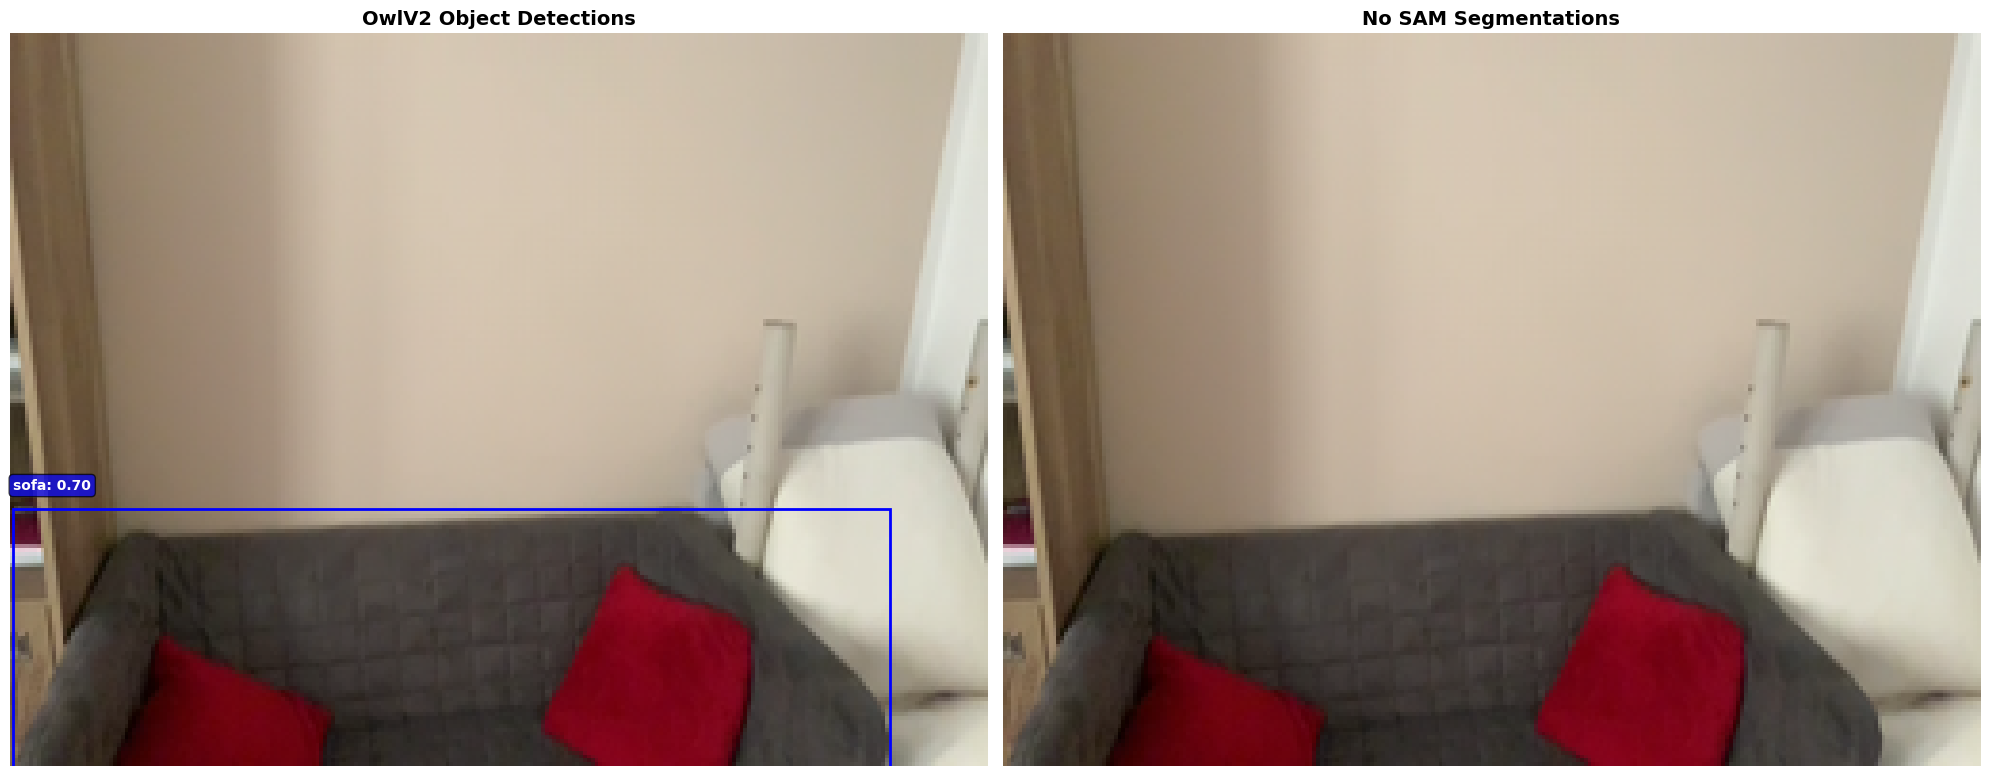


EXAMPLE VISUALIZATION SUMMARY
Frame: 47333473_58547.751.png
OwlV2 detections: 1
SAM segmentations: 0
Success rate: 0.0%


In [22]:
# Run example visualization to see SAM-enhanced detection process on a single frame
print("Running example SAM-enhanced detection on a single frame...")

example_results = visualize_level_c_example(
    config, 
    frame_index=config.LEVEL_C_CONFIG['example_viz_index']
)

## 6. 3D Processing Pipeline


In [14]:
def segment_to_3d_pointcloud(mask: np.ndarray,
                             depth_image: np.ndarray,
                             rgb_image: np.ndarray,
                             camera_intrinsics: np.ndarray,
                             camera_pose: np.ndarray,
                             depth_scale: float = 1000.0,
                             max_points: int = 5000,
                             min_depth: float = 0.1,
                             max_depth: float = 10.0) -> Optional[Dict]:
    """Convert segmented region to 3D point cloud."""
    # Get mask indices
    mask_indices = np.where(mask)
    
    if len(mask_indices[0]) == 0:
        return None
    
    # Extract depth values for masked region
    depths = depth_image[mask_indices] / depth_scale
    
    # Filter valid depths
    valid_mask = (depths > min_depth) & (depths < max_depth)
    if not np.any(valid_mask):
        return None
    
    # Get valid coordinates and depths
    v_coords = mask_indices[0][valid_mask]
    u_coords = mask_indices[1][valid_mask]
    valid_depths = depths[valid_mask]
    
    # Subsample if too many points
    num_points = len(v_coords)
    if num_points > max_points:
        indices = np.random.choice(num_points, max_points, replace=False)
        v_coords = v_coords[indices]
        u_coords = u_coords[indices]
        valid_depths = valid_depths[indices]
    
    # Get camera parameters
    fx, fy = camera_intrinsics[0, 0], camera_intrinsics[1, 1]
    cx, cy = camera_intrinsics[0, 2], camera_intrinsics[1, 2]
    
    # Project to 3D camera coordinates
    x_cam = (u_coords - cx) * valid_depths / fx
    y_cam = (v_coords - cy) * valid_depths / fy
    z_cam = valid_depths
    
    # Stack into points
    points_cam = np.stack([x_cam, y_cam, z_cam], axis=-1)
    
    # Transform to world coordinates
    points_cam_hom = np.concatenate([points_cam, np.ones((len(points_cam), 1))], axis=1)
    camera_pose_inv = np.linalg.inv(camera_pose)
    points_world_hom = (camera_pose_inv @ points_cam_hom.T).T
    points_world = points_world_hom[:, :3]
    
    # Get colors if RGB image provided
    colors = None
    if rgb_image is not None:
        colors = rgb_image[v_coords, u_coords]
        if colors.dtype != np.uint8:
            colors = (colors * 255).astype(np.uint8)
    
    return {
        'points': points_world,
        'colors': colors,
        'num_points': len(points_world)
    }

def compute_pointcloud_iou(pc1: np.ndarray, pc2: np.ndarray, voxel_size: float = 0.05) -> float:
    """Compute IoU between two point clouds using voxelization."""
    # Check for empty point clouds
    if len(pc1) == 0 or len(pc2) == 0:
        return 0.0
    
    # Voxelize both point clouds (PROVIDED)
    def voxelize(points, voxel_size):
        """Convert points to voxel grid indices."""
        voxel_indices = np.floor(points / voxel_size).astype(int)
        return set(map(tuple, voxel_indices))
    
    voxels1 = voxelize(pc1, voxel_size)
    voxels2 = voxelize(pc2, voxel_size)
    
    # ==================== STUDENT TASK 2 ====================
    # TODO: Calculate Intersection over Union (IoU)
    #
    # IoU = (number of shared voxels) / (total unique voxels)
    #
    # Your task:
    # 1. Count voxels that appear in BOTH sets (intersection)
    # 2. Count voxels that appear in EITHER set (union)  
    # 3. Handle edge case where union is 0
    # 4. Return IoU ratio
    #
    # Hint: You can use Python set operations:
    # - & for intersection (elements in both sets)
    # - | for union (elements in either set)
    # - len() to count elements
    
    # TODO: Calculate intersection and union (2 lines)
    intersection =  len(voxels1 & voxels2)
    union = len(voxels1 | voxels2)
    if union == 0:
        return 0.0
    
    # Placeholder - replace with your implementation
    return intersection / union
    # ==================== END STUDENT TASK 2 ====================

def fuse_object_pointclouds(pointcloud_observations: List[Dict],
                            overlap_threshold: float = 0.1,
                            min_observations: int = 2) -> List[Dict]:
    """Fuse overlapping point clouds of same class."""
    if not pointcloud_observations:
        return []
    
    print(f"Fusing {len(pointcloud_observations)} observations with threshold {overlap_threshold}")
    
    # Group by class
    observations_by_class = {}
    for obs in pointcloud_observations:
        class_name = obs['label']
        if class_name not in observations_by_class:
            observations_by_class[class_name] = []
        observations_by_class[class_name].append(obs)
    
    fused_objects = []
    
    for class_name, class_observations in observations_by_class.items():
        if len(class_observations) < min_observations:
            continue
        
        # Build adjacency graph: which observations overlap?
        n = len(class_observations)
        overlaps = np.zeros((n, n))
        
        # Compute pairwise overlaps
        for i in range(n):
            for j in range(i+1, n):
                pc1 = class_observations[i]['points']
                pc2 = class_observations[j]['points']
                
                iou = compute_pointcloud_iou(pc1, pc2, voxel_size=0.1)
                overlaps[i, j] = iou
                overlaps[j, i] = iou
        
        # Find connected components using graph traversal
        visited = [False] * n
        clusters = []
        
        for i in range(n):
            if visited[i]:
                continue
            
            # Start new cluster with DFS
            cluster = []
            stack = [i]
            
            while stack:
                current = stack.pop()
                if visited[current]:
                    continue
                
                visited[current] = True
                cluster.append(current)
                
                # Add neighbors with sufficient overlap
                for j in range(n):
                    if not visited[j] and overlaps[current, j] >= overlap_threshold:
                        stack.append(j)
            
            clusters.append(cluster)
        
        # Create fused objects from clusters
        for cluster in clusters:
            if len(cluster) < min_observations:
                continue
            
            # Merge all points in cluster
            all_points = []
            all_colors = []
            all_scores = []
            
            for obs_idx in cluster:
                obs = class_observations[obs_idx]
                all_points.append(obs['points'])
                if obs.get('colors') is not None:
                    all_colors.append(obs['colors'])
                all_scores.append(obs['score'])
            
            # Concatenate
            fused_points = np.vstack(all_points)
            fused_colors = np.vstack(all_colors) if all_colors else None
            
            # Downsample if too many points
            if len(fused_points) > 5000:
                indices = np.random.choice(len(fused_points), 5000, replace=False)
                fused_points = fused_points[indices]
                if fused_colors is not None:
                    fused_colors = fused_colors[indices]
            
            fused_object = {
                'label': class_name,
                'points': fused_points,
                'colors': fused_colors,
                'num_observations': len(cluster),
                'avg_score': float(np.mean(all_scores)),
                'cluster_id': f"{class_name}_{len(fused_objects)}"
            }
            
            fused_objects.append(fused_object)
    
    print(f"Fused into {len(fused_objects)} objects")
    return fused_objects

In [15]:
def generate_bbox_from_pointcloud(points: np.ndarray,
                                  method: str = 'aabb',
                                  outlier_ratio: float = 0.05) -> Dict:
    """Generate 3D bounding box from point cloud."""
    if len(points) < 10:
        return None
    
    # Remove outliers using statistical filtering
    if outlier_ratio > 0:
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)
        
        # Statistical outlier removal
        pcd_filtered, _ = pcd.remove_statistical_outlier(
            nb_neighbors=20,
            std_ratio=2.0
        )
        
        if len(pcd_filtered.points) < 10:
            filtered_points = points
        else:
            filtered_points = np.asarray(pcd_filtered.points)
    else:
        filtered_points = points
    
    if method == 'obb':
        # Create Open3D point cloud
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(filtered_points)
        
        # Compute oriented bounding box
        try:
            obb = pcd.get_oriented_bounding_box()
            
            # Get OBB parameters
            center = np.asarray(obb.center)
            extent = np.asarray(obb.extent)
            rotation = np.asarray(obb.R)
            
            # Get 8 corners
            corners = np.asarray(obb.get_box_points())
            
            return {
                'center': center,
                'extent': extent,
                'rotation': rotation,
                'corners': corners,
                'type': 'obb'
            }
        except:
            # Fall back to AABB if OBB fails
            method = 'aabb'
    
    if method == 'aabb':
        # Compute axis-aligned bounding box
        min_bounds = np.min(filtered_points, axis=0)
        max_bounds = np.max(filtered_points, axis=0)
        
        center = (min_bounds + max_bounds) / 2
        extent = max_bounds - min_bounds
        
        # Generate 8 corners
        corners = np.array([
            [min_bounds[0], min_bounds[1], min_bounds[2]],
            [max_bounds[0], min_bounds[1], min_bounds[2]],
            [min_bounds[0], max_bounds[1], min_bounds[2]],
            [max_bounds[0], max_bounds[1], min_bounds[2]],
            [min_bounds[0], min_bounds[1], max_bounds[2]],
            [max_bounds[0], min_bounds[1], max_bounds[2]],
            [min_bounds[0], max_bounds[1], max_bounds[2]],
            [max_bounds[0], max_bounds[1], max_bounds[2]],
        ])
        
        return {
            'center': center,
            'extent': extent,
            'rotation': np.eye(3),
            'corners': corners,
            'type': 'aabb'
        }

In [16]:
def process_frame_with_sam(frame_data: Dict,
                          owl_processor, owl_model,
                          sam_processor, sam_model,
                          device: str,
                          config: Config) -> Dict:
    """Process a single frame with OwlV2 detection and SAM segmentation."""
    results = {
        'frame_name': frame_data['frame_name'],
        'detections_2d': [],
        'segments': [],
        'pointclouds': []
    }
    
    try:
        # Run OwlV2 detection
        detections_2d, image = detect_objects_in_frame(
            frame_data['rgb_path'],
            config.OBJECT_CLASSES,
            owl_processor,
            owl_model,
            device,
            threshold=config.LEVEL_C_CONFIG['detection_threshold']
        )
        
        if not detections_2d:
            return results
        
        results['detections_2d'] = detections_2d
        
        # Load depth and RGB images
        depth_image = cv2.imread(frame_data['depth_path'], cv2.IMREAD_UNCHANGED)
        rgb_image = np.array(image)
        
        # Process each detection with SAM
        for detection in detections_2d:
            # Generate segmentation mask using SAM
            mask = segment_with_sam_bbox(
                image,
                detection['bbox'],
                sam_model,
                sam_processor,
                device,
                confidence_threshold=config.LEVEL_C_CONFIG['sam_confidence_threshold']
            )
            
            if mask is None:
                continue
            
            # Convert segment to 3D point cloud
            pc_data = segment_to_3d_pointcloud(
                mask,
                depth_image,
                rgb_image,
                frame_data['camera_intrinsics'],
                frame_data['camera_pose'],
                depth_scale=config.TSDF_CONFIG['depth_scale'],
                max_points=config.LEVEL_C_CONFIG.get('max_points_per_object', 2000)
            )
            
            if pc_data is None or pc_data['num_points'] < 10:
                continue
            
            # Store results
            results['segments'].append({
                'bbox': detection['bbox'],
                'label': detection['label'],
                'score': detection['score'],
                'mask': mask
            })
            
            results['pointclouds'].append({
                'label': detection['label'],
                'score': detection['score'],
                'points': pc_data['points'],
                'colors': pc_data['colors'],
                'frame_name': frame_data['frame_name']
            })
            
    except Exception as e:
        print(f"Error processing frame {frame_data['frame_name']}: {e}")
    
    return results


In [17]:
def generate_final_detections(fused_objects: List[Dict]) -> List[Dict]:
    """Generate final detection results from fused point cloud objects."""
    final_detections = []
    
    for fused_obj in fused_objects:
        bbox_data = generate_bbox_from_pointcloud(
            fused_obj['points'],
            method='aabb',
            outlier_ratio=0.15
        )
        
        if bbox_data is None:
            continue
        
        final_detections.append({
            'label': fused_obj['label'],
            'score': fused_obj['avg_score'],
            'center_3d_world': bbox_data['center'].tolist(),
            'bbox_3d_world': bbox_data['corners'].tolist(),
            'extent': bbox_data['extent'].tolist(),
            'rotation': bbox_data['rotation'].tolist(),
            'bbox_type': bbox_data['type'],
            'num_observations': fused_obj['num_observations'],
            'pointcloud': fused_obj['points'],
            'colors': fused_obj['colors']
        })
    
    return final_detections

## 7. Full Pipeline Execution

Now let's run the complete SAM-enhanced pipeline across all frames:

In [18]:
# Execute the complete SAM-enhanced 3D object detection pipeline
print("Running full SAM-enhanced pipeline across all frames...")

pipeline_results = run_full_pipeline(config)

Running full SAM-enhanced pipeline across all frames...

FULL PIPELINE EXECUTION
Loading OWLv2 model...
Model loaded on device: cuda
Loading SAM model (base)...
SAM model loaded on device: cuda
Loaded 540 camera poses
Selected 180 frames from 540 total
Validating and aligning 180 frames...
Aligned 180 frames (skipped 0)
Processing 180 frames in 36 batches of 5...


Frame processing complete: 62/180 frames successful
Fusing 90 observations with threshold 0.5
Fused into 4 objects
Pipeline: 180 frames → 90 pointclouds → 4 fused → 4 final
Building TSDF point cloud...
Loaded 540 camera poses
Selected 180 frames from 540 total
Validating and aligning 180 frames...
Aligned 180 frames (skipped 0)
TSDF integration: using 180 frames
  Volume: 30.0m³
  Resolution: 512³ voxels
  Batch size: 20 frames
Processing 180 frames in 9 batches...
  Batch 1/9: frames 0-19


  Batch 2/9: frames 20-39


  Batch 3/9: frames 40-59


  Batch 4/9: frames 60-79


  Batch 5/9: frames 80-99


  Batch 6/9: frames 100-119


  Batch 7/9: frames 120-139


  Batch 8/9: frames 140-159


  Batch 9/9: frames 160-179


Extracting mesh from TSDF volume...
Converting mesh to point cloud...
Downsampling from 200000 points...
Final TSDF point cloud: 36882 points
Loading ground truth annotations from: ARKitScenesData/47333473/47333473_frames/../47333473_3dod_annotation.json
Successfully processed 6 ground truth annotations
Loading ground truth mesh from: ARKitScenesData/47333473/47333473_frames/../47333473_3dod_mesh.ply
Loaded mesh with 75000 points

LEVEL C (OWLV2 + SAM) EVALUATION
Detections: 4
Ground Truth: 6
Mean IoU: 0.133
Median IoU: 0.000
GT Matched (IoU>0.1): 2/6
✗ NOT PASSED: mIoU 0.133 < 0.25 requirement
Results: ✗ FAILED | mIoU: 0.133 | Detections: 4
Visualizing: Level C: SAM-Enhanced Detection - Scene 47333473


HTML(value='<div id="5cbf27c1-21ea-460b-94e0-a75f6b871519"><style onload="eval(atob(\'KGFzeW5jIGZ1bmN0aW9uICgp…

Viewer()

3D visualization complete
Full pipeline complete!
